In [1]:
from google.colab import drive

# Montez votre Google Drive
drive.mount('/content/drive')

# Spécifiez le chemin où se trouvent vos données
data_dir = '/content/drive/My Drive/malaria/malaria_hematie_dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas pillow opencv-python


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive

# Montez votre Google Drive
drive.mount('/content/drive')

# Spécifiez le chemin où se trouvent vos données
data_dir = '/content/drive/MyDrive/malaria/malaria_hematie_dataset'
categories = ['parasitized', 'uninfected']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = Image.open(img_path).convert('RGB')
        image = image.resize((128, 128))  # Redimensionner les images si nécessaire
        data.append(np.array(image))
        labels.append(category)

data = np.array(data)
labels = np.array(labels)

In [5]:
# Normaliser les images
data = data / 255.0


In [6]:
# Encoder les labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [7]:
# Faire de la data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

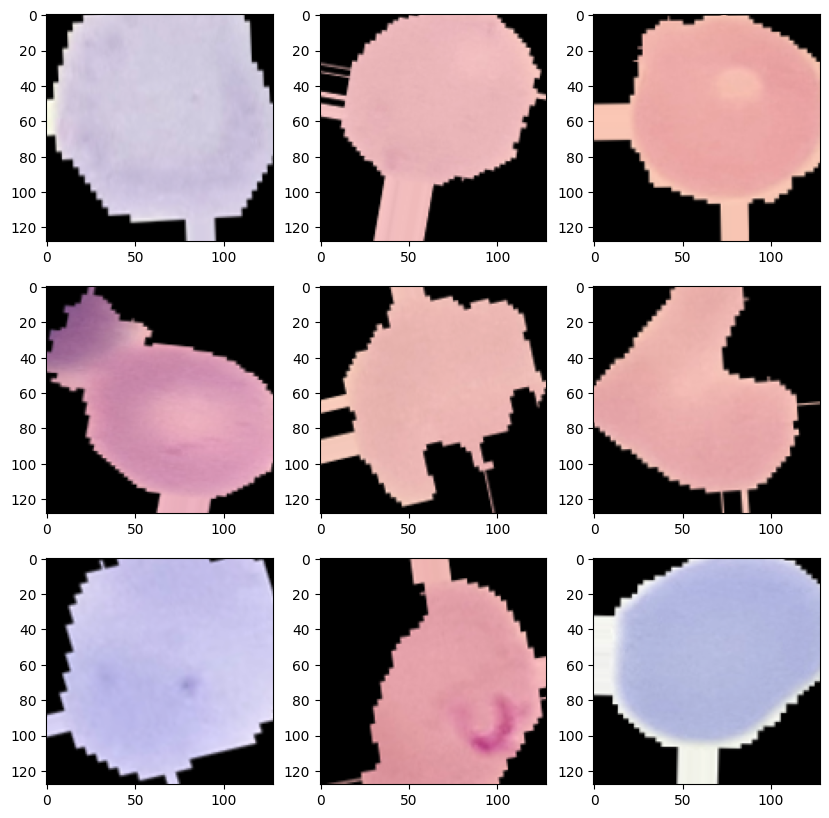

In [8]:
plt.figure(figsize=(10, 10))
for X_batch, y_batch in datagen.flow(data, labels_encoded, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

# Callback pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Callback pour la réduction du taux d'apprentissage
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


In [10]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense

In [11]:
model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D


# Charger le modèle VGG16 pré-entraîné
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Ajouter des couches de classification
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Définir le modèle complet
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

# Geler les couches convolutionnelles de VGG16
for layer in base_model_vgg16.layers:
    layer.trainable = False

model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
from tensorflow.keras.applications import ResNet50

# Charger le modèle ResNet50 pré-entraîné
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Ajouter des couches de classification
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Définir le modèle complet
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

# Geler les couches convolutionnelles de ResNet50
for layer in base_model_resnet50.layers:
    layer.trainable = False

model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Entraîner le modèle from scratch
history_scratch = model_scratch.fit(data, labels_encoded, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Entraîner le modèle VGG16
history_vgg16 = model_vgg16.fit(data, labels_encoded, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Entraîner le modèle ResNet50
history_resnet50 = model_resnet50.fit(data, labels_encoded, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr])


In [ ]:
from sklearn.metrics import confusion_matrix

# Prédire les classes pour chaque modèle
predictions_scratch = model_scratch.predict(test_data)
predictions_vgg16 = model_vgg16.predict(test_data)
predictions_resnet50 = model_resnet50.predict(test_data)

# Convertir les prédictions en classes (0 ou 1)
predictions_scratch_classes = (predictions_scratch > 0.5).astype(int)
predictions_vgg16_classes = (predictions_vgg16 > 0.5).astype(int)
predictions_resnet50_classes = (predictions_resnet50 > 0.5).astype(int)

# Calculer la matrice de confusion pour chaque modèle
confusion_scratch = confusion_matrix(test_labels, predictions_scratch_classes)
confusion_vgg16 = confusion_matrix(test_labels, predictions_vgg16_classes)
confusion_resnet50 = confusion_matrix(test_labels, predictions_resnet50_classes)

print("Matrice de Confusion - Modèle From Scratch :\n", confusion_scratch)
print("\nMatrice de Confusion - Modèle VGG16 :\n", confusion_vgg16)
print("\nMatrice de Confusion - Modèle ResNet50 :\n", confusion_resnet50)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Définir une fonction pour calculer toutes les métriques
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    return accuracy, precision, recall, f1

# Calculer les métriques pour chaque modèle
accuracy_scratch, precision_scratch, recall_scratch, f1_scratch = calculate_metrics(test_labels, predictions_scratch_classes)
accuracy_vgg16, precision_vgg16, recall_vgg16, f1_vgg16 = calculate_metrics(test_labels, predictions_vgg16_classes)
accuracy_resnet50, precision_resnet50, recall_resnet50, f1_resnet50 = calculate_metrics(test_labels, predictions_resnet50_classes)

print("Métriques de Performance - Modèle From Scratch :")
print("Accuracy : {:.2f}".format(accuracy_scratch))
print("Precision : {:.2f}".format(precision_scratch))
print("Recall : {:.2f}".format(recall_scratch))
print("F1-Score : {:.2f}".format(f1_scratch))

print("\nMétriques de Performance - Modèle VGG16 :")
print("Accuracy : {:.2f}".format(accuracy_vgg16))
print("Precision : {:.2f}".format(precision_vgg16))
print("Recall : {:.2f}".format(recall_vgg16))
print("F1-Score : {:.2f}".format(f1_vgg16))

print("\nMétriques de Performance - Modèle ResNet50 :")
print("Accuracy : {:.2f}".format(accuracy_resnet50))
print("Precision : {:.2f}".format(precision_resnet50))
print("Recall : {:.2f}".format(recall_resnet50))
print("F1-Score : {:.2f}".format(f1_resnet50))


In [ ]:
import matplotlib.pyplot as plt

# Calculer les courbes ROC pour chaque modèle
fpr_scratch, tpr_scratch, _ = roc_curve(test_labels, predictions_scratch)
fpr_vgg16, tpr_vgg16, _ = roc_curve(test_labels, predictions_vgg16)
fpr_resnet50, tpr_resnet50, _ = roc_curve(test_labels, predictions_resnet50)

# Calculer l'AUC pour chaque modèle
auc_scratch = auc(fpr_scratch, tpr_scratch)
auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)
auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Afficher les courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_scratch, tpr_scratch, label='Modèle From Scratch (AUC = {:.2f})'.format(auc_scratch))
plt.plot(fpr_vgg16, tpr_vgg16, label='Modèle VGG16 (AUC = {:.2f})'.format(auc_vgg16))
plt.plot(fpr_resnet50, tpr_resnet50, label='Modèle ResNet50 (AUC = {:.2f})'.format(auc_resnet50))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend()
plt.show()
